In [2]:
import psycopg2

# Connect to your PostgreSQL database
conn = psycopg2.connect(
    dbname="telecom", 
    user="postgres", 
    password="123456", 
    host="localhost", 
    port="5432"
)

In [14]:
import pandas as pd

import sys
import os

# Set the path to the parent directory (use raw string to handle backslashes)
sys.path.append(os.path.abspath(r'C:\Gedebie\finTech AI\week2\telecom_data_analysis'))

# # Import the fetch_data function from the utils module
# from utils import fetch_data

# Example usage
df = fetch_data(conn)


# Step 1: Aggregate session frequency, session duration, and total traffic per customer (MSISDN)
aggregated_data = df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',                # Session frequency (number of sessions)
    'Dur. (ms)': 'sum',                  # Total session duration
    'HTTP DL (Bytes)': 'sum',             # Total download traffic
    'HTTP UL (Bytes)': 'sum'              # Total upload traffic
})

# Step 2: Calculate total traffic (Download + Upload)
aggregated_data['Total Traffic (Bytes)'] = aggregated_data['HTTP DL (Bytes)'] + aggregated_data['HTTP UL (Bytes)']

# Step 3: Rename columns for clarity
aggregated_data.rename(columns={'Bearer Id': 'Session Frequency', 'Dur. (ms)': 'Total Duration (ms)'}, inplace=True)

# Step 4: Find the top 10 customers for each engagement metric

# Top 10 customers by session frequency
top_10_frequency = aggregated_data.sort_values(by='Session Frequency', ascending=False).head(10)

# Top 10 customers by total session duration
top_10_duration = aggregated_data.sort_values(by='Total Duration (ms)', ascending=False).head(10)

# Top 10 customers by total traffic (Download + Upload)
top_10_traffic = aggregated_data.sort_values(by='Total Traffic (Bytes)', ascending=False).head(10)

# Step 5: Print results
print("Top 10 customers by session frequency:")
print(top_10_frequency)

print("\nTop 10 customers by total session duration:")
print(top_10_duration)

print("\nTop 10 customers by total traffic (Download + Upload):")
print(top_10_traffic)


Top 10 customers by session frequency:
               Session Frequency  Total Duration (ms)  HTTP DL (Bytes)  \
MSISDN/Number                                                            
3.362632e+10                  18            8791927.0        1720802.0   
3.362578e+10                  17           18553754.0         195754.0   
3.361489e+10                  17            9966898.0       70195935.0   
3.365973e+10                  16            4035428.0       32041442.0   
3.376054e+10                  15            9279434.0       32862797.0   
3.367588e+10                  15            4865947.0       99718963.0   
3.366716e+10                  13            8744914.0       25248306.0   
3.360452e+10                  12            5207990.0       60745241.0   
3.362708e+10                  12            4703516.0        1913830.0   
3.360313e+10                  12            6287761.0       10701111.0   

               HTTP UL (Bytes)  Total Traffic (Bytes)  
MSISDN/Number   

In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Aggregate the engagement metrics per customer
aggregated_data = df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',                # Session frequency (number of sessions)
    'Dur. (ms)': 'sum',                  # Total session duration
    'HTTP DL (Bytes)': 'sum',            # Total download traffic
    'HTTP UL (Bytes)': 'sum'             # Total upload traffic
})

# Step 2: Calculate total traffic (Download + Upload)
aggregated_data['Total Traffic (Bytes)'] = aggregated_data['HTTP DL (Bytes)'] + aggregated_data['HTTP UL (Bytes)']

# Step 3: Rename columns for clarity
aggregated_data.rename(columns={
    'Bearer Id': 'Session Frequency',
    'Dur. (ms)': 'Total Duration (ms)',
    'HTTP DL (Bytes)': 'Download Traffic (Bytes)',
    'HTTP UL (Bytes)': 'Upload Traffic (Bytes)'
}, inplace=True)

# Step 4: Normalize the engagement metrics using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(aggregated_data[['Session Frequency', 'Total Duration (ms)', 'Total Traffic (Bytes)']])

# Step 5: Run K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_data['Cluster'] = kmeans.fit_predict(normalized_data)

# Step 6: Analyze and print the results
# Add cluster labels to the original dataframe
aggregated_data['Cluster'] = kmeans.labels_

# Step 7: Show results: Customers grouped into three clusters
print("Top 10 customers and their engagement clusters:")
print(aggregated_data.head(10))

# Step 8: Count the number of customers in each cluster
print("\nNumber of customers in each cluster:")
print(aggregated_data['Cluster'].value_counts())

# Optional: Calculate the centroids of each cluster to understand the groupings
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Session Frequency', 'Total Duration (ms)', 'Total Traffic (Bytes)'])
print("\nCluster centroids (representative engagement levels for each group):")
print(cluster_centers)


Top 10 customers and their engagement clusters:
               Session Frequency  Total Duration (ms)  \
MSISDN/Number                                           
3.360100e+10                   1             116720.0   
3.360100e+10                   1             181230.0   
3.360100e+10                   1             134969.0   
3.360101e+10                   1              49878.0   
3.360101e+10                   2              37104.0   
3.360101e+10                   2             253983.0   
3.360101e+10                   2             128360.0   
3.360101e+10                   1              86399.0   
3.360101e+10                   2             495702.0   
3.360102e+10                   1             124854.0   

               Download Traffic (Bytes)  Upload Traffic (Bytes)  \
MSISDN/Number                                                     
3.360100e+10                        0.0                     0.0   
3.360100e+10                        0.0                     0.0   

   Cluster  Session Frequency_min  Session Frequency_max  \
0        0                      2                     18   
1        1                      0                      1   
2        2                      1                      6   

   Session Frequency_mean  Session Frequency_sum  Total Duration (ms)_min  \
0                2.444234                  71027                  18235.0   
1                0.995048                  77367                   7142.0   
2                2.488889                    112                  56123.0   

   Total Duration (ms)_max  Total Duration (ms)_mean  Total Duration (ms)_sum  \
0               18553754.0             260133.023057             7.559206e+09   
1                1573420.0             103532.143109             8.049831e+09   
2                 515339.0             217798.844444             9.800948e+06   

   Total Traffic (Bytes)_min  Total Traffic (Bytes)_max  \
0               0.000000e+00               1.583609e+10   
1      

C:\Users\CraftSoft\AppData\Local\Temp\ipykernel_4004\3142428582.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary_reset, x='Cluster', y='Session Frequency_mean', palette='viridis')
C:\Users\CraftSoft\AppData\Local\Temp\ipykernel_4004\3142428582.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary_reset, x='Cluster', y='Total Duration (ms)_mean', palette='viridis')
C:\Users\CraftSoft\AppData\Local\Temp\ipykernel_4004\3142428582.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summa

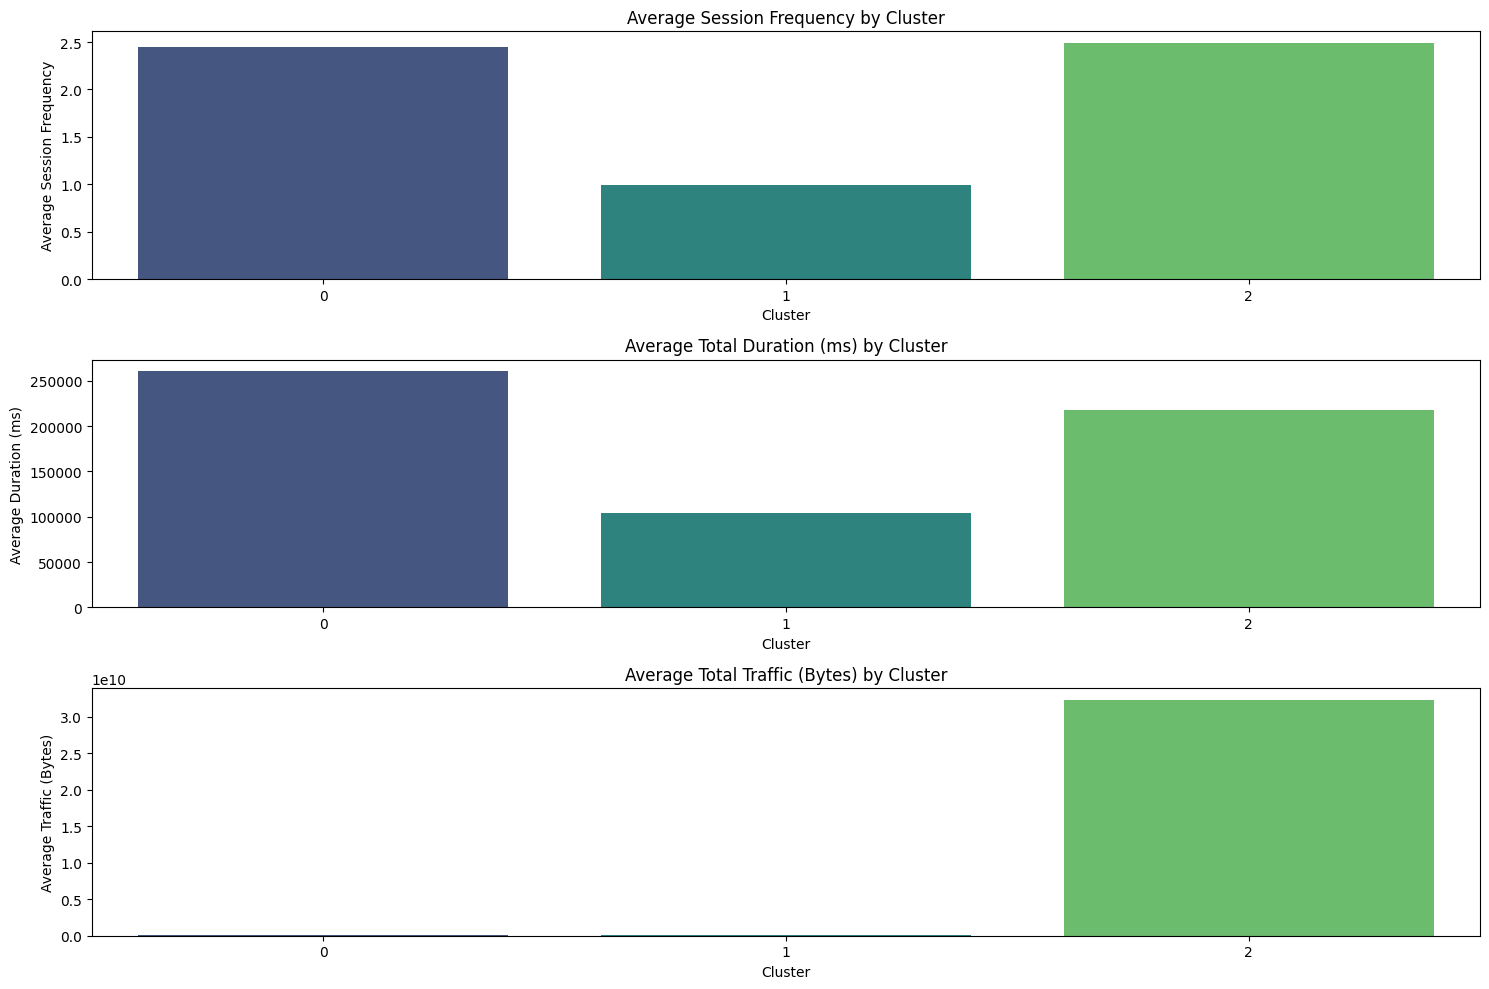

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset the index and print the DataFrame to understand its structure
cluster_summary_reset = cluster_summary.reset_index()
print(cluster_summary_reset.head())

# Plotting
plt.figure(figsize=(15, 10))

# Plot for Session Frequency
plt.subplot(3, 1, 1)
sns.barplot(data=cluster_summary_reset, x='Cluster', y='Session Frequency_mean', palette='viridis')
plt.title('Average Session Frequency by Cluster')
plt.ylabel('Average Session Frequency')

# Plot for Total Duration
plt.subplot(3, 1, 2)
sns.barplot(data=cluster_summary_reset, x='Cluster', y='Total Duration (ms)_mean', palette='viridis')
plt.title('Average Total Duration (ms) by Cluster')
plt.ylabel('Average Duration (ms)')

# Plot for Total Traffic
plt.subplot(3, 1, 3)
sns.barplot(data=cluster_summary_reset, x='Cluster', y='Total Traffic (Bytes)_mean', palette='viridis')
plt.title('Average Total Traffic (Bytes) by Cluster')
plt.ylabel('Average Traffic (Bytes)')

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

import sys
import os

# Set the path to the parent directory (use raw string to handle backslashes)
sys.path.append(os.path.abspath(r'C:\Gedebie\finTech AI\week2\telecom_data_analysis'))
from utils import fetch_data

# Example usage
df = fetch_data(conn)

import pandas as pd

# Check and verify the columns in your DataFrame
print(df.columns)

# Assuming df is your DataFrame with the correct columns: 
# 'MSISDN/Number', 'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)', etc.

# Step 1: Calculate the total traffic (DL + UL) for each application
df['Google Total (Bytes)'] = df['Google DL (Bytes)'] + df['Google UL (Bytes)']
df['Email Total (Bytes)'] = df['Email DL (Bytes)'] + df['Email UL (Bytes)']
df['Youtube Total (Bytes)'] = df['Youtube DL (Bytes)'] + df['Youtube UL (Bytes)']
df['Netflix Total (Bytes)'] = df['Netflix DL (Bytes)'] + df['Netflix UL (Bytes)']
df['Gaming Total (Bytes)'] = df['Gaming DL (Bytes)'] + df['Gaming UL (Bytes)']
df['Other Total (Bytes)'] = df['Other DL (Bytes)'] + df['Other UL (Bytes)']

# Step 2: Reshape the data so that each application is a separate row for each user
traffic_columns = ['Google Total (Bytes)', 'Email Total (Bytes)', 'Youtube Total (Bytes)',
                   'Netflix Total (Bytes)', 'Gaming Total (Bytes)', 'Other Total (Bytes)']

# Ensure the 'MSISDN/Number' column exists in your DataFrame
if 'MSISDN/Number' not in df.columns:
    raise KeyError("The 'MSISDN/Number' column is not present in the DataFrame. Check your DataFrame.")

df_melted = df.melt(id_vars=['MSISDN/Number'], value_vars=traffic_columns, 
                    var_name='Application', value_name='Total Traffic (Bytes)')

# Step 3: Rename 'Application' column to remove 'Total (Bytes)' using a raw string for proper escaping
df_melted['Application'] = df_melted['Application'].str.replace(r' Total \(Bytes\)', '')

# Step 4: Sort the users by traffic for each application
sorted_traffic = df_melted.sort_values(by=['Application', 'Total Traffic (Bytes)'], ascending=[True, False])

# Step 5: Select the top 10 most engaged users per application
top_10_per_application = sorted_traffic.groupby('Application').head(10)

# Display the top 10 users for each application
print(top_10_per_application)




Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


C:\Users\CraftSoft\AppData\Local\Temp\ipykernel_26160\4124024756.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Application', y='Total Traffic (Bytes)', data=top_3_apps, palette='viridis')


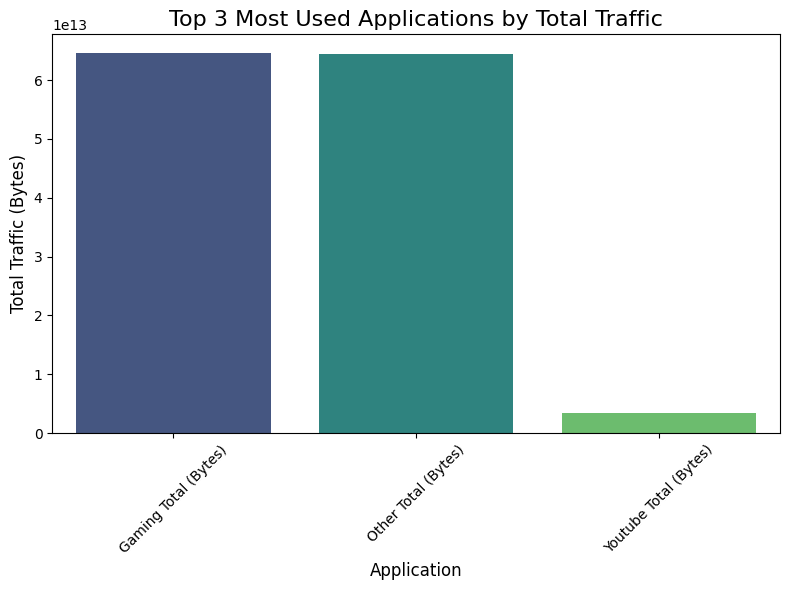

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_melted is already created from the previous steps.

# Step 1: Aggregate the total traffic per application
total_traffic_per_app = df_melted.groupby('Application')['Total Traffic (Bytes)'].sum().reset_index()

# Step 2: Sort the applications by total traffic in descending order and select the top 3
top_3_apps = total_traffic_per_app.sort_values(by='Total Traffic (Bytes)', ascending=False).head(3)

# Step 3: Plot the top 3 most used applications
plt.figure(figsize=(8, 6))
sns.barplot(x='Application', y='Total Traffic (Bytes)', data=top_3_apps, palette='viridis')

# Step 4: Add titles and labels
plt.title('Top 3 Most Used Applications by Total Traffic', fontsize=16)
plt.xlabel('Application', fontsize=12)
plt.ylabel('Total Traffic (Bytes)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


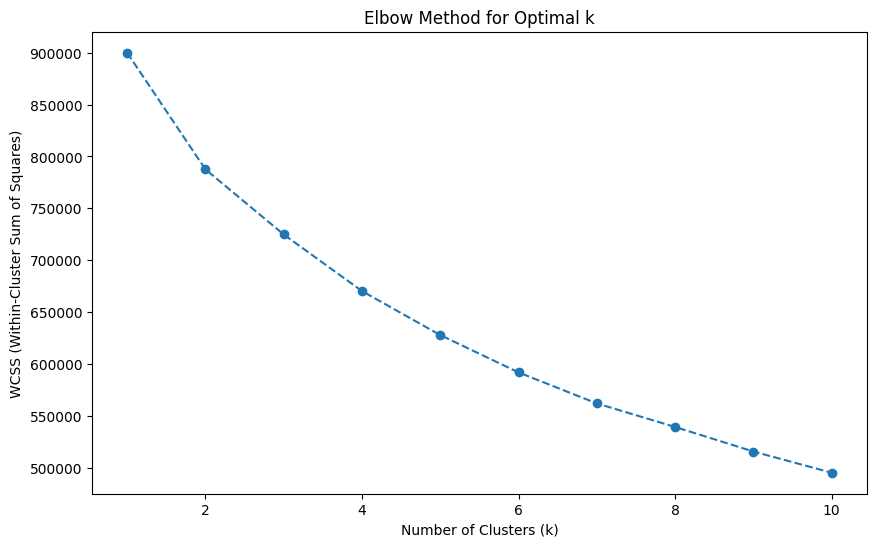

In [13]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming df is the DataFrame containing the traffic data
traffic_columns = ['Google Total (Bytes)', 'Email Total (Bytes)', 'Youtube Total (Bytes)',
                   'Netflix Total (Bytes)', 'Gaming Total (Bytes)', 'Other Total (Bytes)']

# Step 1: Feature Scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[traffic_columns])

# Step 2: Apply K-means for different values of k and calculate WCSS (Within-Cluster Sum of Squares)
wcss = []
k_range = range(1, 11)  # Checking k values from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Step 3: Plot the Elbow Method graph to find the optimal k
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


TCP Retransmission (Bytes):
Top 10: [2172057825.5, 2150738719.5, 2147215982.5, 2145732475.0, 2144060430.0, 2137745856.5, 2134323675.0, 2130808019.5, 2130087072.5, 2127329821.5]
Bottom 10: [43.0, 48.5, 53.0, 54.0, 56.5, 64.0, 64.5, 67.0, 67.0, 71.5]
Most Frequent 10: [10784786.467576498, 10405604.135170965, 380494.33240553306, 10405622.135170965, 379848.33240553306, 379875.33240553306, 10405616.135170965, 381159.33240553306, 380488.33240553306, 10406287.135170965]

RTT (ms):
Top 10: [48462.0, 32320.5, 27906.0, 27424.0, 13639.0, 13150.0, 12961.0, 12857.5, 12694.0, 12369.0]
Bottom 10: [0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.5, 3.0, 3.0]
Most Frequent 10: [63.729294482330296, 14.5, 19.5, 19.0, 20.0, 15.0, 14.0, 24.5, 20.5, 15.5]

Throughput (kbps):
Top 10: [191131.0, 156622.0, 152149.5, 150273.0, 141965.5, 140572.0, 138576.0, 138102.5, 137026.0, 134944.0]
Bottom 10: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Most Frequent 10: [31.5, 7.5, 48.5, 45.0, 49.0, 48.0, 49.5, 44.5, 45.5, 46.5